In [287]:
import numpy as np
import pandas as pd
from pyproj import Proj
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [282]:
#Open Surrogate files, skip first 25 rows of meta data, delimiter is a tab, no headers
df = pd.read_csv('C:/Users/vlang/Desktop/USA_100_NOFILL.txt', skiprows=25, delimiter=r"\t", header=None)
df2= pd.read_csv('C:/Users/vlang/Desktop/USA_950_NOFILL.txt', skiprows=25, delimiter=r"\t", header=None)
# set dataframe headers
df.columns = ['Surrogate','FIPS','Row','Col','Frac','!','Numerator','Denom','QASUM']
df2.columns = ['Surrogate','FIPS','Row','Col','Frac','!','Numerator','Denom','QASUM']

C:\Users\vlang\AppData\Local\Temp\ipykernel_15596\312096209.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('C:/Users/vlang/Desktop/USA_100_NOFILL.txt', skiprows=25, delimiter=r"\t", header=None)
C:\Users\vlang\AppData\Local\Temp\ipykernel_15596\312096209.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df2= pd.read_csv('C:/Users/vlang/Desktop/USA_950_NOFILL.txt', skiprows=25, delimiter=r"\t", header=None)


In [288]:
# Get lat/lon from LADCO grid and find corners of domain
# this is to be used for map extents
grid='D:/EmissionsData_EPS361/latlon_ChicagoLADCO_d03.nc'
cmaq_lon,cmaq_lat=np.array(Dataset(grid)['lon']),np.array(Dataset(grid)['lat'])
llat,ulat,llon,ulon=cmaq_lat.min(), cmaq_lat.max(), cmaq_lon.min(), cmaq_lon.max()

In [289]:
#projection input from first line of surrogate file "GRID... ""
# variables are listed in order they appear on the first line 
xorig= -132000  #lower left ref
yorig= -420000   # lower left ref
ycell= 1333.33  # meters
xcell= 1333.33   # meters 
rows= 1260   
cols= 1170
# Lambert proj
palp= 33. # 1st par lat
pbet= 45. # 2nd par lat
xcent= -97.  # center lon
# -97 repeats for some reason -not sure why 
ycent= 40     # center lat

#find Lambert projection given projection details, find lat/lon boundaries using pyproj Proj package
# https://proj.org/    Documentation on the package itself
# https://proj.org/operations/projections/lcc.html  #Documentation on using Proj for LCC projections
proj_trans = Proj(proj='lcc', lat_1=palp, lat_2=pbet, lon_0=xcent, lat_0=ycent, a=6370000.0, b=6370000.0)
# lower left corner of grid
lonO, latO = proj_trans(xorig, yorig, inverse=True)
# Upper right corner of grid 
lonE, latE = proj_trans((xorig + (xcell * rows)),(yorig + (ycell * cols)), inverse=True)

# Convert row/col to lon/lat using defined projection 
lat= np.zeros(len(df)) ; lon= np.zeros(len(df))
for i in range(len(df)): 
    lon[i], lat[i]= proj_trans((xorig + (xcell * df['Row'][i])),(yorig + (ycell * df['Col'][i])), inverse=True)
        
df['lat'] = lat ; df['lon']= lon
#df['lat']= np.round(df['lat'], decimals=4); df['lon']= np.round(df['lon'], decimals=4)

In [290]:
#set up empty numpy arrays- we want to leave missing lat/lon data empty not zeros
longitude = np.empty((rows,cols)) ; latitude = np.empty((rows,cols))

#Create 2d arrays by looping through rows/cols to find lat/lon 
for i in range(rows): 
    for j in range(cols):
        longitude[i,j], latitude[i,j]= proj_trans((xorig + (xcell * i)),(yorig + (ycell * j)), inverse=True)
        
# set up empty 2d array for value
fraction = np.empty((rows,cols))  
# Find i,j index 
for x in range(len(df)):
    i,j =df['Row'][x]-1, df['Col'][x]-1  
    fraction[i,j] = df.Frac[x]         

Text(0.5, 1.0, 'Fraction \n Population_NoFill_1.33km \n USA_100_NOFILL.txt')

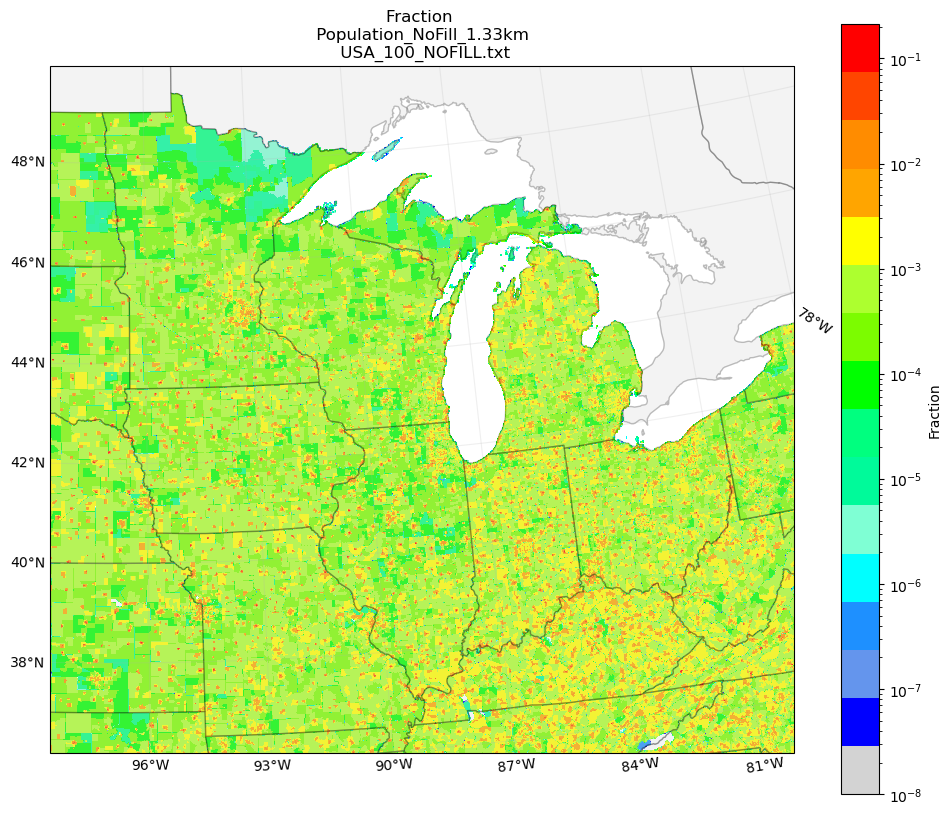

In [317]:
# Set up figure to plot 
fig = plt.figure(figsize=(12,10))

# Define colorbar colors to match LADCOS surrogate plots
# https://www.ladco.org/technical/modeling-results/ladco-2016-modeling/#Emissions/Surrogates/LADCO1_1260x1170
cmap= mpl.colors.ListedColormap(['lightgrey','blue','cornflowerblue','dodgerblue','cyan','aquamarine','mediumspringgreen','springgreen','lime','lawngreen','greenyellow','yellow','orange','darkorange','orangered','red'])

# set up grid projection and axis extent
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-97, central_latitude=40))
ax.set_extent([longitude.min()+.35,longitude.max()-4,latitude.min()+1.30,latitude.max()-1.35])

#plot surrogates and colorbar, convert to Platecarree projection to match LADCO
plt.pcolormesh(longitude, latitude, fraction, transform = ccrs.PlateCarree(), cmap=cmap, norm=mpl.colors.LogNorm())
plt.colorbar(label='Fraction', orientation='vertical')

#Add state boundaries and lat/lon labels 
ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black',alpha=.25, facecolor='lightgrey')
gl=ax.gridlines(draw_labels=True, transform = ccrs.PlateCarree(), alpha=.2, x_inline=False, y_inline=False)
gl.top_labels=False ; gl.right_labels=False

ax.set_title('Fraction \n Population_NoFill_1.33km \n USA_100_NOFILL.txt')

#attemps to use bounds to match LADCO colorbar ticks 
#bounds =[0,10e-9,10e-8,10e-7,10e-6,10e-5,10e-4,10e-3,.01,.1]
#norm = mpl.colors.BoundaryNorm(bounds,cmap.N)
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label='Fraction', orientation='vertical')
#plt.colorbar(label='Fraction', orientation='vertical')



Text(0.5, 1.0, 'Fraction \n Population_NoFill_1.33km \n USA_100_NOFILL.txt')

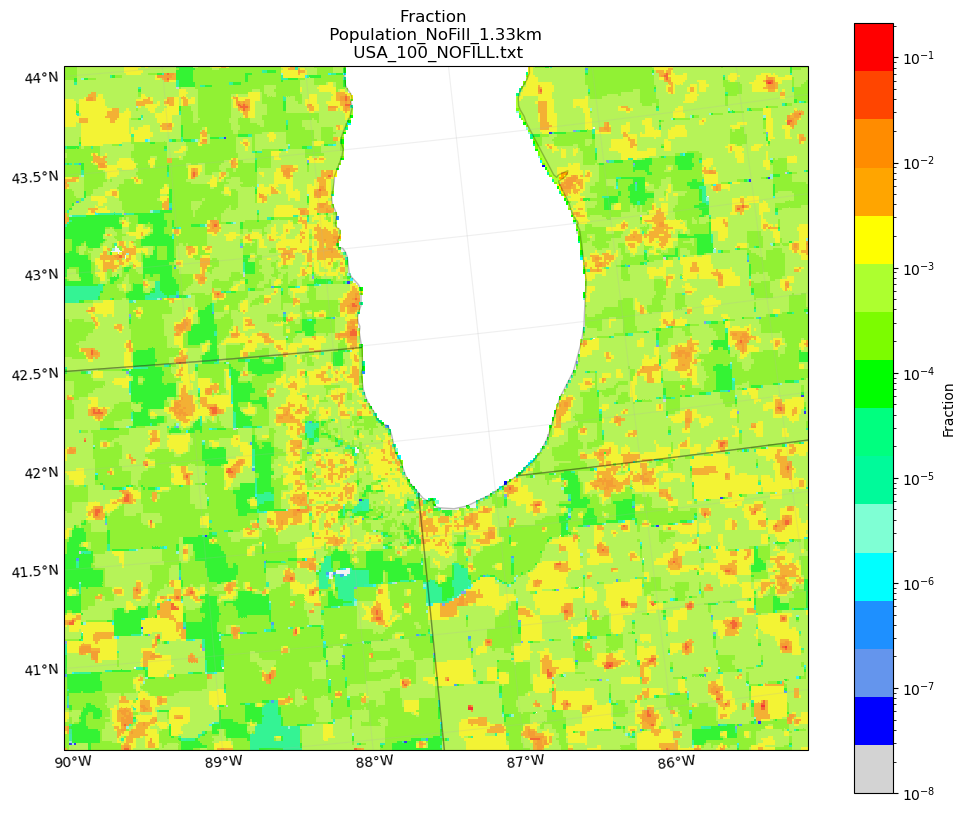

In [319]:
# Set up figure to plot 
fig = plt.figure(figsize=(12,10))

# Define colorbar colors to match LADCOS surrogate plots
# https://www.ladco.org/technical/modeling-results/ladco-2016-modeling/#Emissions/Surrogates/LADCO1_1260x1170
cmap= mpl.colors.ListedColormap(['lightgrey','blue','cornflowerblue','dodgerblue','cyan','aquamarine','mediumspringgreen','springgreen','lime','lawngreen','greenyellow','yellow','orange','darkorange','orangered','red'])

# set up grid projection and axis extent
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-97, central_latitude=40))
ax.set_extent([np.amin(cmaq_lon)+0.35, np.amax(cmaq_lon)-0.55,np.amin(cmaq_lat)+0.355,np.amax(cmaq_lat)-.35])

#plot surrogates and colorbar, convert to Platecarree projection to match LADCO
plt.pcolormesh(longitude, latitude, fraction, transform = ccrs.PlateCarree(), cmap=cmap, norm=mpl.colors.LogNorm())
plt.colorbar(label='Fraction', orientation='vertical')

#Add state boundaries and lat/lon labels 
ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black',alpha=.25, facecolor='lightgrey')
gl=ax.gridlines(draw_labels=True, transform = ccrs.PlateCarree(), alpha=.2, x_inline=False, y_inline=False)
gl.top_labels=False ; gl.right_labels=False

ax.set_title('Fraction \n Population_NoFill_1.33km \n USA_100_NOFILL.txt')

#attemps to use bounds to match LADCO colorbar ticks 
#bounds =[0,10e-9,10e-8,10e-7,10e-6,10e-5,10e-4,10e-3,.01,.1]
#norm = mpl.colors.BoundaryNorm(bounds,cmap.N)
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label='Fraction', orientation='vertical')
#plt.colorbar(label='Fraction', orientation='vertical')


In [221]:
# project Warehouse surrogates next

#find Lambert projection given projection details, find lat/lon boundaries
proj_trans = Proj(proj='lcc', lat_1=palp, lat_2=pbet, lon_0=xcent, lat_0=ycent, a=6370000.0, b=6370000.0)
# lower left corner 
lonO, latO = proj_trans(xorig, yorig, inverse=True)
# Upper right corner
lonE, latE = proj_trans((xorig + (xcell * rows)),(yorig + (ycell * cols)), inverse=True)

#convert row/col to lon/lat using proj_trans
lat= np.zeros(len(df2)) ; lon= np.zeros(len(df2))
for i in range(len(df2)): 
    lon[i], lat[i]= proj_trans((xorig + (xcell * df2['Row'][i])),(yorig + (ycell * df2['Col'][i])), inverse=True)
        
df2['lat'] = lat ; df2['lon']= lon

#set up empty numpy arrays- we want to leave missing lat/lon data empty not zeros
longitude2 = np.empty((rows,cols)) ; latitude2 = np.empty((rows,cols))
#Create 2d arrays by looping through rows/cols to find lat/lon 
for i in range(rows): 
    for j in range(cols):
        longitude2[i,j], latitude2[i,j]= proj_trans((xorig + (xcell * i)),(yorig + (ycell * j)), inverse=True)
        
# set up empty 2d array for value
fraction2 = np.empty((rows,cols))  
# Find i,j index 
for x in range(len(df2)):
    i,j =df2['Row'][x]-1, df2['Col'][x]-1  
    fraction2[i,j] = df2.Frac[x] 

Text(0.5, 1.0, 'Fraction \n WarehousePoint_NOFILL_1.33km')

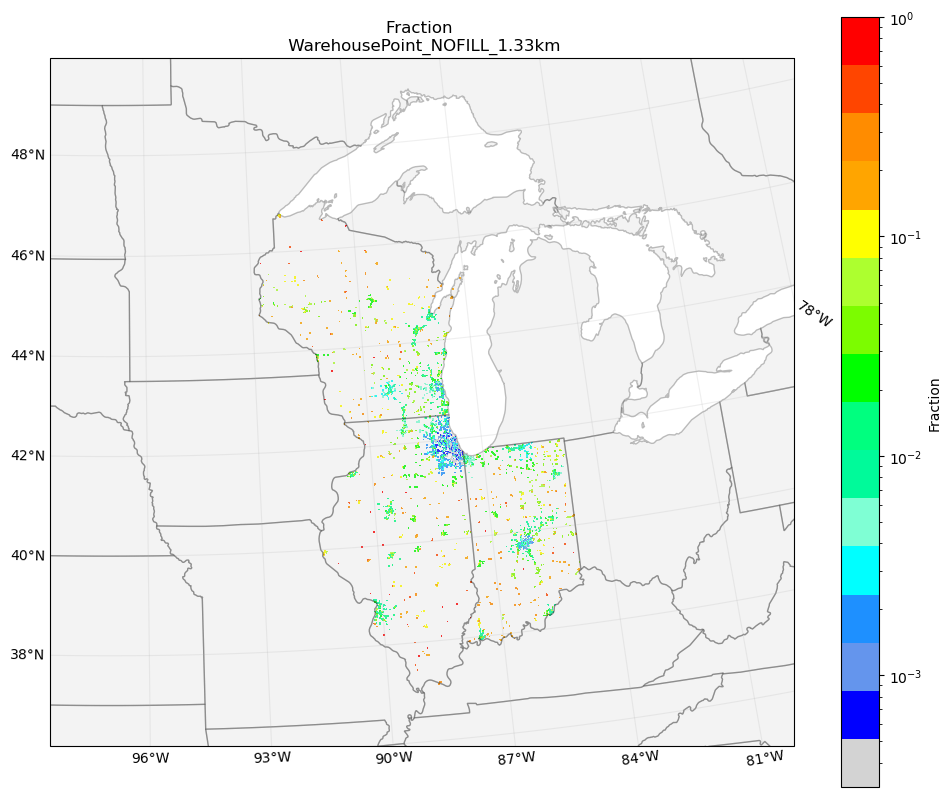

In [323]:
# Set up figure to plot 
fig = plt.figure(figsize=(12,10))

# Define colorbar colors to match LADCOS surrogate plots
# https://www.ladco.org/technical/modeling-results/ladco-2016-modeling/#Emissions/Surrogates/LADCO1_1260x1170
cmap= mpl.colors.ListedColormap(['lightgrey','blue','cornflowerblue','dodgerblue','cyan','aquamarine','mediumspringgreen','springgreen','lime','lawngreen','greenyellow','yellow','orange','darkorange','orangered','red'])

# set up grid projection and axis extent
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-97, central_latitude=40))
ax.set_extent([longitude.min()+.35,longitude.max()-4,latitude.min()+1.30,latitude.max()-1.35])

#plot surrogates and colorbar, convert to Platecarree projection to match LADCO
plt.pcolormesh(longitude2, latitude2, fraction2, transform = ccrs.PlateCarree(), cmap=cmap, norm=mpl.colors.LogNorm())
plt.colorbar(label='Fraction', orientation='vertical')

#Add state boundaries and lat/lon labels 
ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black',alpha=.25, facecolor='lightgrey')
gl=ax.gridlines(draw_labels=True, transform = ccrs.PlateCarree(), alpha=.2, x_inline=False, y_inline=False)
gl.top_labels=False ; gl.right_labels=False

ax.set_title('Fraction \n WarehousePoint_NOFILL_1.33km')

#attemps to use bounds to match LADCO colorbar ticks 
#bounds =[0,10e-9,10e-8,10e-7,10e-6,10e-5,10e-4,10e-3,.01,.1]
#norm = mpl.colors.BoundaryNorm(bounds,cmap.N)
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label='Fraction', orientation='vertical')
#plt.colorbar(label='Fraction', orientation='vertical')


Text(0.5, 1.0, 'Fraction \n WarehousePoint_NoFill_1.33km')

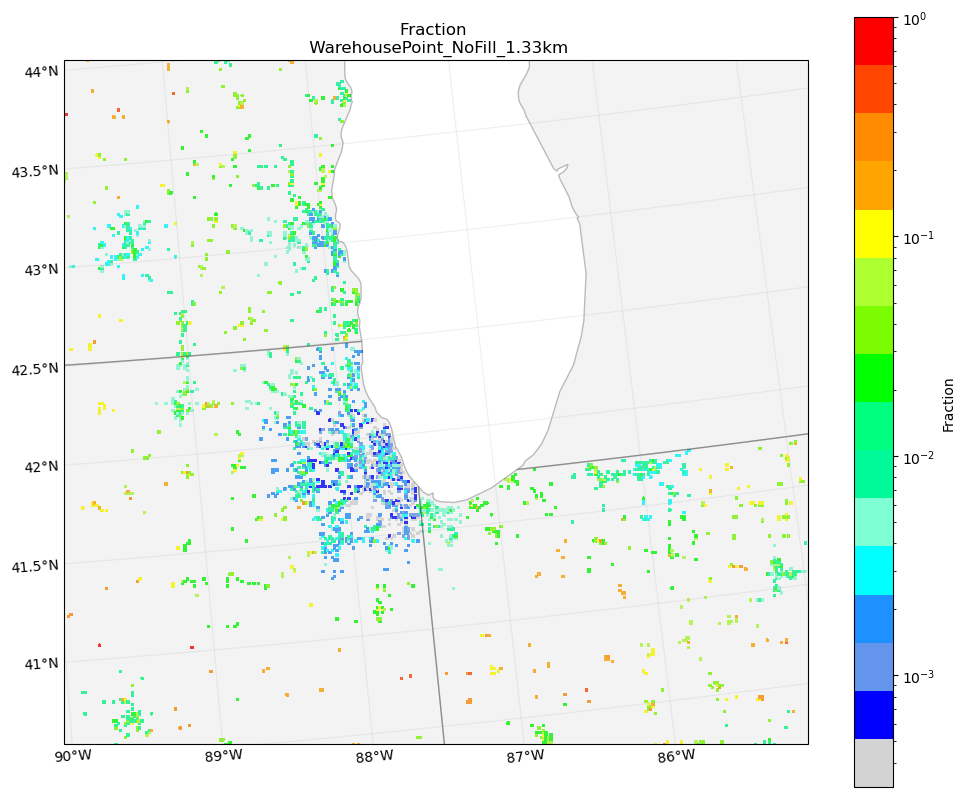

In [321]:
# Set up figure to plot 
fig = plt.figure(figsize=(12,10))

# Define colorbar colors to match LADCOS surrogate plots
# https://www.ladco.org/technical/modeling-results/ladco-2016-modeling/#Emissions/Surrogates/LADCO1_1260x1170
cmap= mpl.colors.ListedColormap(['lightgrey','blue','cornflowerblue','dodgerblue','cyan','aquamarine','mediumspringgreen','springgreen','lime','lawngreen','greenyellow','yellow','orange','darkorange','orangered','red'])

# set up grid projection and axis extent
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-97, central_latitude=40))
ax.set_extent([np.amin(cmaq_lon)+0.35, np.amax(cmaq_lon)-0.55,np.amin(cmaq_lat)+0.355,np.amax(cmaq_lat)-.35])

#plot surrogates and colorbar, convert to Platecarree projection to match LADCO
plt.pcolormesh(longitude2, latitude2, fraction2, transform = ccrs.PlateCarree(), cmap=cmap, norm=mpl.colors.LogNorm())
plt.colorbar(label='Fraction', orientation='vertical')

#Add state boundaries and lat/lon labels 
ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black',alpha=.25, facecolor='lightgrey')
gl=ax.gridlines(draw_labels=True, transform = ccrs.PlateCarree(), alpha=.2, x_inline=False, y_inline=False)
gl.top_labels=False ; gl.right_labels=False

ax.set_title('Fraction \n WarehousePoint_NoFill_1.33km')

#attemps to use bounds to match LADCO colorbar ticks 
#bounds =[0,10e-9,10e-8,10e-7,10e-6,10e-5,10e-4,10e-3,.01,.1]
#norm = mpl.colors.BoundaryNorm(bounds,cmap.N)
#plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label='Fraction', orientation='vertical')
#plt.colorbar(label='Fraction', orientation='vertical')


In [324]:
# Find any differences in LADCO vs my surrogates
import filecmp
# Load files
file1=open('C:/Users/vlang/Desktop/smoke_spatial_surrogates_LADCO1_1260x1170/LADCO1_1260x1170/USA_100_NOFILL1.txt')
file2=open('C:/Users/vlang/Desktop/USA_100_NOFILL1.txt')

file1_lines = file1.readlines()
file2_lines = file2.readlines()

for i in range(len(file1_lines)):
    if file1_lines[i] != file2_lines[i]:
        print("Line " + str(i+1) + " doesn't match.")
        print("------------------------")
        print("File1: " + file1_lines[i])
        print("File2: " + file2_lines[i])

file1.close()
file2.close()

Line 129268 doesn't match.
------------------------
File1:   100	36029	 1193	  670	0.00743090	!	6821.459075	917985.961880	0.595957

File2:   100	36029	 1193	  670	0.00743090	!	6821.459074	917985.961880	0.595957

Line 416331 doesn't match.
------------------------
File1:   100	18099	  756	  451	0.00030944	!	14.553160	47030.536784	0.000309

File2:   100	18099	  756	  451	0.00030944	!	14.553160	47030.536783	0.000309

Line 416332 doesn't match.
------------------------
File1:   100	18099	  757	  451	0.00045623	!	21.456582	47030.536784	0.000766

File2:   100	18099	  757	  451	0.00045623	!	21.456582	47030.536783	0.000766

Line 416333 doesn't match.
------------------------
File1:   100	18099	  758	  451	0.00036303	!	17.073502	47030.536784	0.001129

File2:   100	18099	  758	  451	0.00036303	!	17.073502	47030.536783	0.001129

Line 416334 doesn't match.
------------------------
File1:   100	18099	  759	  451	0.00024659	!	11.597181	47030.536784	0.001375

File2:   100	18099	  759	  451	0.00024659